#  MODIS Water Clustering Analysis

Version: 0.1.0

Date modified: 05.01.2023

Modified by: Amanda Burke

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path   
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split 

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [90]:
DATA_VERSION='v2.0.0'
training_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{DATA_VERSION}'

GPU = True

MODEL = 'rf'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
FRAC_LAND=0.5


##############################
#VERSION 4.2.0
#TILE = 'Golden'#v4.2.0
#offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day','tileID']
##############################

##############################
#VERSION 2.0.0
TILE = 'GLOBAL'#v4.2.0
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day']
##############################

glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE))
data_paths = sorted([fv for fv in glob.glob(glob_string)])

#Only want the one with 4.2.0 because the other file doesnt work. 
print(data_paths)
data_path = data_paths[0]
print(data_path)


num_datapoints = 10000000

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v2.0.0/MOD09_GLOBAL_5516128_2_0_0.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v2.0.0/MOD09_GLOBAL_5516128_2_0_0.parquet.gzip


In [3]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
              applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        if land:
            print('Imbalancing data, sampling {} from water'.format(frac))
        else:
            print(f'Imbalancing data, sampling {frac} from land, {1-frac} from water')
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Start off with just surface reflectance bands 1,2

### Input data

In [4]:
colsToDrop = ['sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [5]:
colsToDrop

['sur_refl_b03_1',
 'sur_refl_b04_1',
 'sur_refl_b05_1',
 'sur_refl_b06_1',
 'sur_refl_b07_1',
 'ndvi',
 'ndwi1',
 'ndwi2']

In [55]:
X, X_test, y, y_test = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                imbalance=True,
                                frac=FRAC_LAND,
                                trainTestSplit=True
                                )

X = X.iloc[:num_datapoints,:] 
y = y.iloc[:num_datapoints] 

X_test = X_test.iloc[:num_datapoints,:] 
y_test = y_test.iloc[:num_datapoints] 

print(f'subset data shape: {X.shape}, {y.shape}')

Imbalancing data, sampling 0.5 from land, 0.5 from water
subset data shape: (10000, 2), (10000,)


#### separate the land and water points

In [56]:
#Getting the indices that are associated with land (0) and water (1)
y_water_ind = np.where(y>0.5)[0]
y_land_ind = np.where(y<0.5)[0]

#Subset the X AND y data to later subset with the clusters and then combine for RFA
X_water = X.iloc[y_water_ind,:]
y_water = y.iloc[y_water_ind]

X_land = X.iloc[y_land_ind,:]
y_land = y.iloc[y_land_ind]

In [8]:
_ = [print(column) for column in X.columns]

sur_refl_b01_1
sur_refl_b02_1


### kmeans

Text(0, 0.5, 'sur_refl_b02_1')

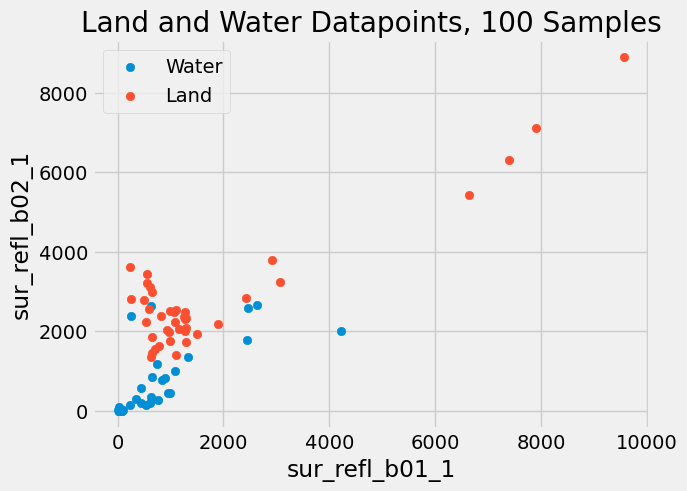

In [67]:
# plt.scatter(X_water.values[:,0], X_water.values[:,1],label='Water')
# plt.scatter(X_land.values[:,0], X_land.values[:,1],label='Land')
# plt.title(f'Land and Water Datapoints, {num_datapoints} Samples')
# plt.legend()
# plt.xlabel(X_water.columns[0])
# plt.ylabel(X_water.columns[1])

In [12]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

In [14]:
%%time
kme_water =  KMeans(n_clusters=5, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

CPU times: user 71.9 ms, sys: 11.3 ms, total: 83.1 ms
Wall time: 8.43 ms


In [15]:
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)

57
[2 4 1 0 2 0 2 1 0 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 4 4 2 2 2 2 0 2
 2 0 2 3 2 2 0 4 1 1 2 2 2 2 4 1 2 2 2 2]
[[ 994.5        1297.125     ]
 [4068.4        3552.2       ]
 [ 154.18421053   90.42105263]
 [5887.         5580.        ]
 [2662.2        2480.        ]]


Text(0, 0.5, 'sur_refl_b02_1')

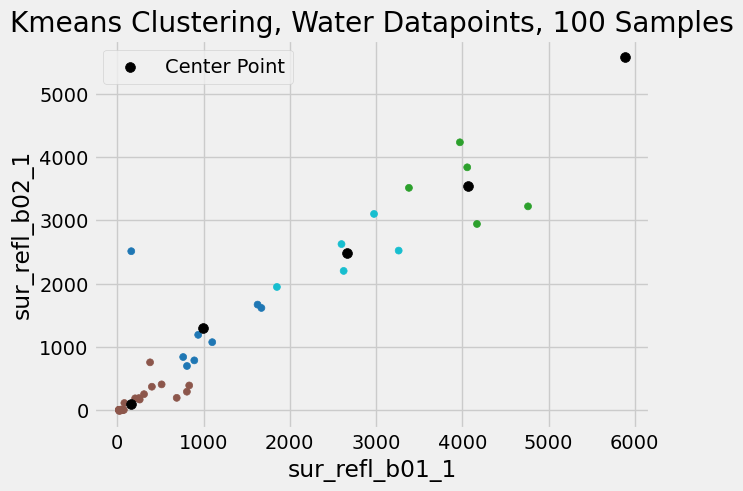

In [48]:
plt.scatter(X_water.values[:,0], X_water.values[:,1],
            c=kmeans_output_water,cmap='tab10',s=25)
plt.scatter(kme_water.cluster_centers_[:,0],kme_water.cluster_centers_[:,1],
            label='Center Point',c='k',s=50)
plt.title(f'Kmeans Clustering, Water Datapoints, {num_datapoints} Samples')
plt.legend()
plt.xlabel(X_water.columns[0])
plt.ylabel(X_water.columns[1])

Text(0, 0.5, 'sur_refl_b02_1')

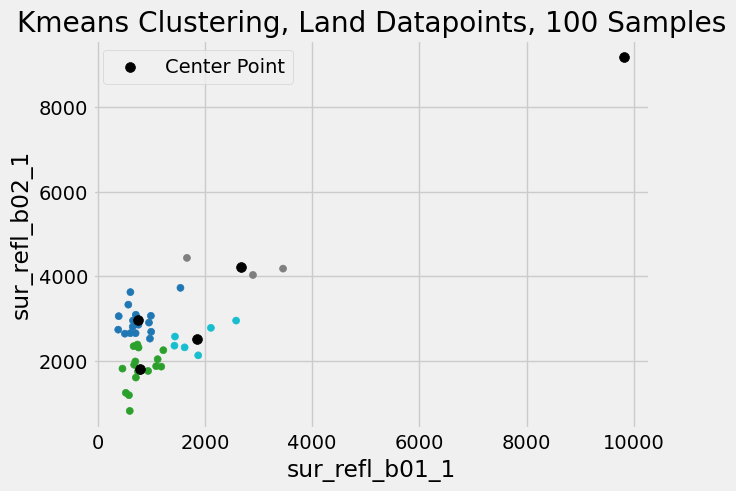

In [42]:
# plt.scatter(X_land.values[:,0], X_land.values[:,1],
#             c=kmeans_output_land,cmap='tab10',s=25)
# plt.scatter(kme_land.cluster_centers_[:,0],kme_land.cluster_centers_[:,1],
#             label='Center Point',c='k',s=50)
# plt.title(f'Kmeans Clustering, Land Datapoints, {num_datapoints} Samples')
# plt.legend()
# plt.xlabel(X_land.columns[0])
# plt.ylabel(X_land.columns[1])

### kmeans land versus water

In [9]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

In [57]:
%%time
kme_land =  KMeans(n_clusters=3, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

CPU times: user 281 ms, sys: 65.2 ms, total: 346 ms
Wall time: 22.5 ms


In [58]:
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)

3726
[2 1 2 ... 0 1 1]
[[ 540.50814332 1417.07274701]
 [ 585.70419426 3900.4602649 ]
 [ 757.05107952 2618.0073723 ]]


In [59]:
%%time
kme_water =  KMeans(n_clusters=3, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

CPU times: user 394 ms, sys: 66.6 ms, total: 460 ms
Wall time: 16.3 ms


In [60]:
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)

6274
[0 0 1 ... 0 0 0]
[[  67.29560724   35.74625323]
 [ 942.08447489  952.9543379 ]
 [4479.48387097 4580.19354839]]


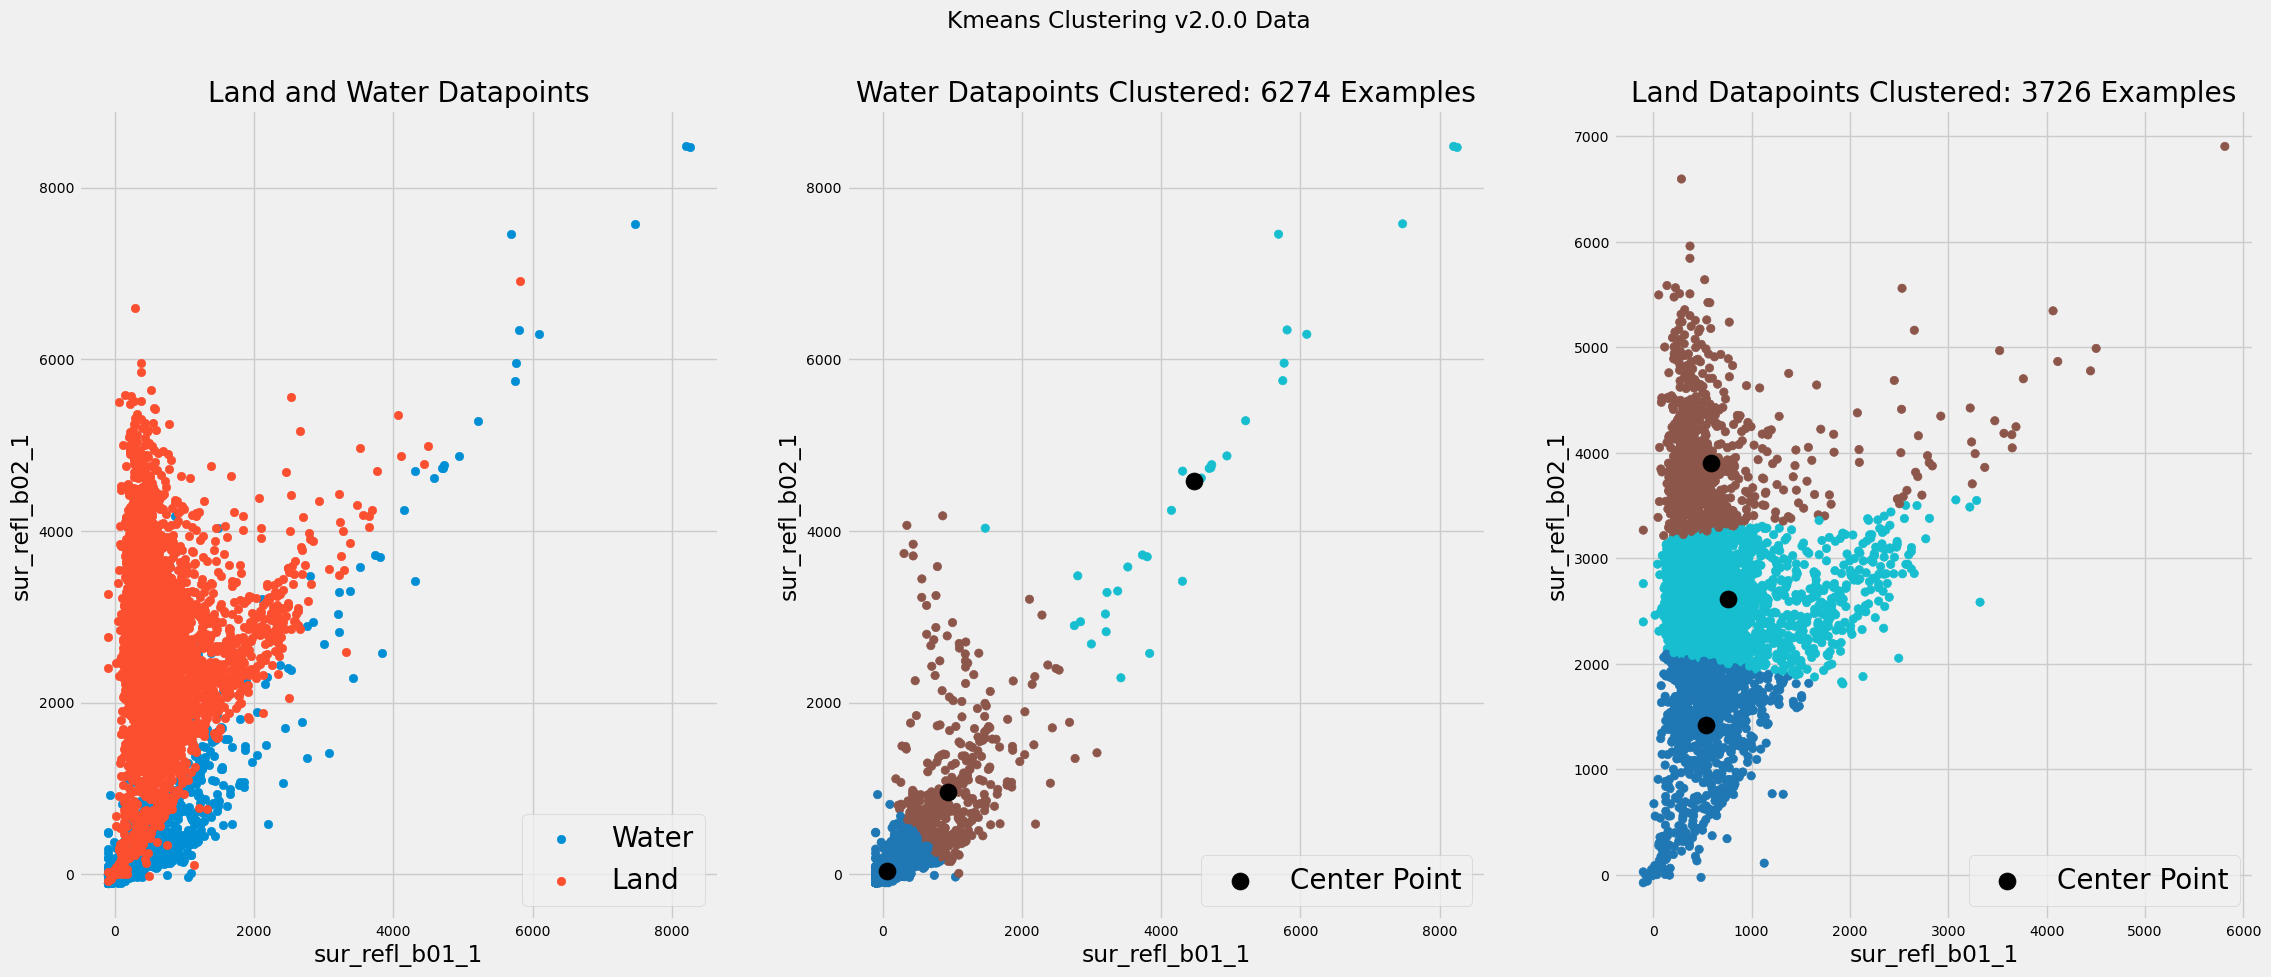

In [61]:
fig = plt.figure(figsize = (25, 10))

plt.suptitle(f'Kmeans Clustering {DATA_VERSION} Data')


ax1 = plt.subplot(131)
ax1.scatter(X_water.values[:,0], X_water.values[:,1],label='Water')
ax1.scatter(X_land.values[:,0], X_land.values[:,1],label='Land')
ax1.set_title(f'Land and Water Datapoints')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.tick_params(axis='both', which='minor', labelsize=10)
ax1.legend(loc='lower right',fontsize="20")
ax1.set_xlabel(X_water.columns[0])
ax1.set_ylabel(X_water.columns[1])


ax2 = plt.subplot(132)
ax2.set_title(f'Water Datapoints Clustered: {len(X_water)} Examples')
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='minor', labelsize=10)

ax2.scatter(X_water.values[:,0], X_water.values[:,1],c=kmeans_output_water,cmap='tab10')
ax2.scatter(kme_water.cluster_centers_[:,0],kme_water.cluster_centers_[:,1],
            label='Center Point',c='k',s=150)
ax2.legend(loc='lower right',fontsize="20")
ax2.set_xlabel(X_water.columns[0])
ax2.set_ylabel(X_water.columns[1])


ax3 = plt.subplot(133)
ax3.tick_params(axis='both', which='major', labelsize=10)
ax3.tick_params(axis='both', which='minor', labelsize=10)

ax3.set_title(f'Land Datapoints Clustered: {len(X_land)} Examples')
ax3.scatter(X_land.values[:,0], X_land.values[:,1],c=kmeans_output_land,cmap='tab10')
ax3.scatter(kme_land.cluster_centers_[:,0],kme_land.cluster_centers_[:,1],label='Center Point',c='k',s=150)
ax3.legend(loc='lower right',fontsize="20")
ax3.set_xlabel(X_land.columns[0])
ax3.set_ylabel(X_land.columns[1])

# plt.legend()
plt.show()

### Birch

In [46]:
%%time
br = Birch(n_clusters=5).fit(X)
birch_output = br.predict(X)

MemoryError: unable to allocate array data.

Text(0, 0.5, 'sur_refl_b02_1')

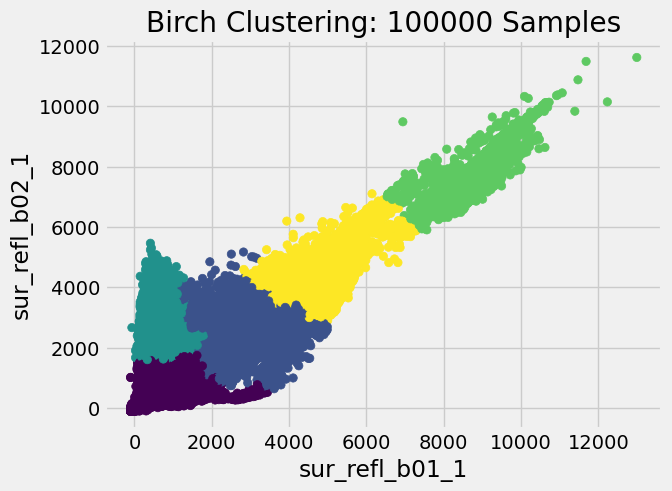

In [39]:
plt.scatter(X.values[:,0], X.values[:,1],c=birch_output)
plt.title(f'Birch Clustering: {num_datapoints} Samples')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

### Spectral 

In [17]:
%%time
spectral = SpectralClustering(
        n_clusters=5,
        #affinity="nearest_neighbors",
        random_state=42).fit_predict(X)

CPU times: user 42min 33s, sys: 3min 47s, total: 46min 21s
Wall time: 1min 10s


Text(0, 0.5, 'sur_refl_b02_1')

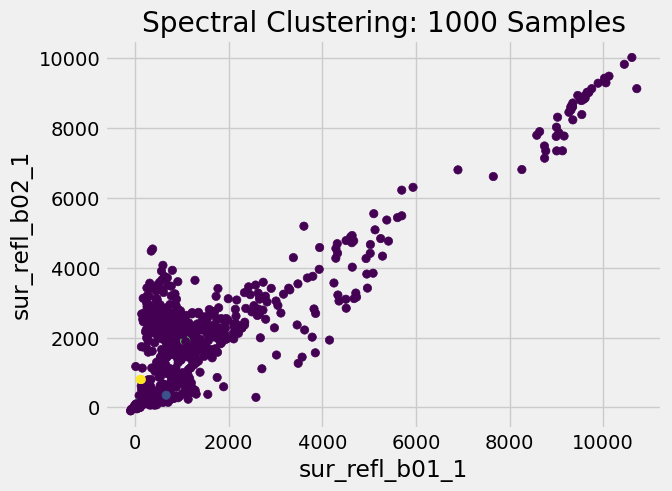

In [20]:
plt.scatter(X.values[:,0], X.values[:,1],c=spectral)
plt.title(f'Spectral Clustering: {num_datapoints} Samples')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

## Adding more input bands

In [49]:
colsToDrop = [
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [50]:
X, X_test, y, y_test = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                imbalance=True,
                                frac=FRAC_LAND,
                                trainTestSplit=True
                                )

X = X.iloc[:num_datapoints,:] 
y = y.iloc[:num_datapoints] 

X_test = X_test.iloc[:num_datapoints,:] 
y_test = y_test.iloc[:num_datapoints] 

print(f'subset data shape: {X.shape}, {y.shape}')

Imbalancing data, sampling 0.5 from land, 0.5 from water
subset data shape: (100, 3), (100,)


In [55]:
#Getting the indices that are associated with land (0) and water (1)
y_water_ind_3D = np.where(y>0.5)[0]
y_land_ind_3D = np.where(y<0.5)[0]

#Subset the X AND y data to later subset with the clusters and then combine for RFA
X_water_3D = X.iloc[y_water_ind_3D,:]
y_water_3D = y.iloc[y_water_ind_3D]

X_land_3D = X.iloc[y_land_ind_3D,:]
y_land_3D = y.iloc[y_land_ind_3D]

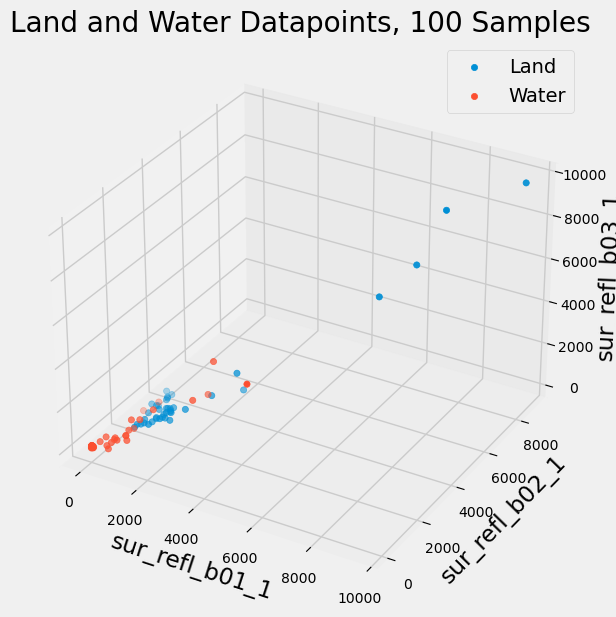

In [66]:
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection ="3d")
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)

plt.title(f'Land and Water Datapoints, {num_datapoints} Samples')
ax.scatter(X_land_3D.values[:,0], X_land_3D.values[:,1], X_land_3D.values[:,2],label='Land')
ax.scatter(X_water_3D.values[:,0], X_water_3D.values[:,1], X_water_3D.values[:,2],label='Water')

ax.set_xlabel(X_land.columns[0])
ax.set_ylabel(X_land.columns[1])
ax.set_zlabel(X_land.columns[2])
plt.legend()

plt.show()

### Kmeans

In [88]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

In [89]:
%%time
kme_water_3D =  KMeans(n_clusters=5, **common_params).fit(X_water_3D)
kmeans_output_water_3D = kme_water_3D.predict(X_water_3D)

CPU times: user 65.2 ms, sys: 9.15 ms, total: 74.4 ms
Wall time: 6.91 ms


In [90]:
%%time
kme_land_3D =  KMeans(n_clusters=5, **common_params).fit(X_land_3D)
kmeans_output_land_3D = kme_land_3D.predict(X_land_3D)

CPU times: user 56 ms, sys: 8.16 ms, total: 64.1 ms
Wall time: 5.57 ms


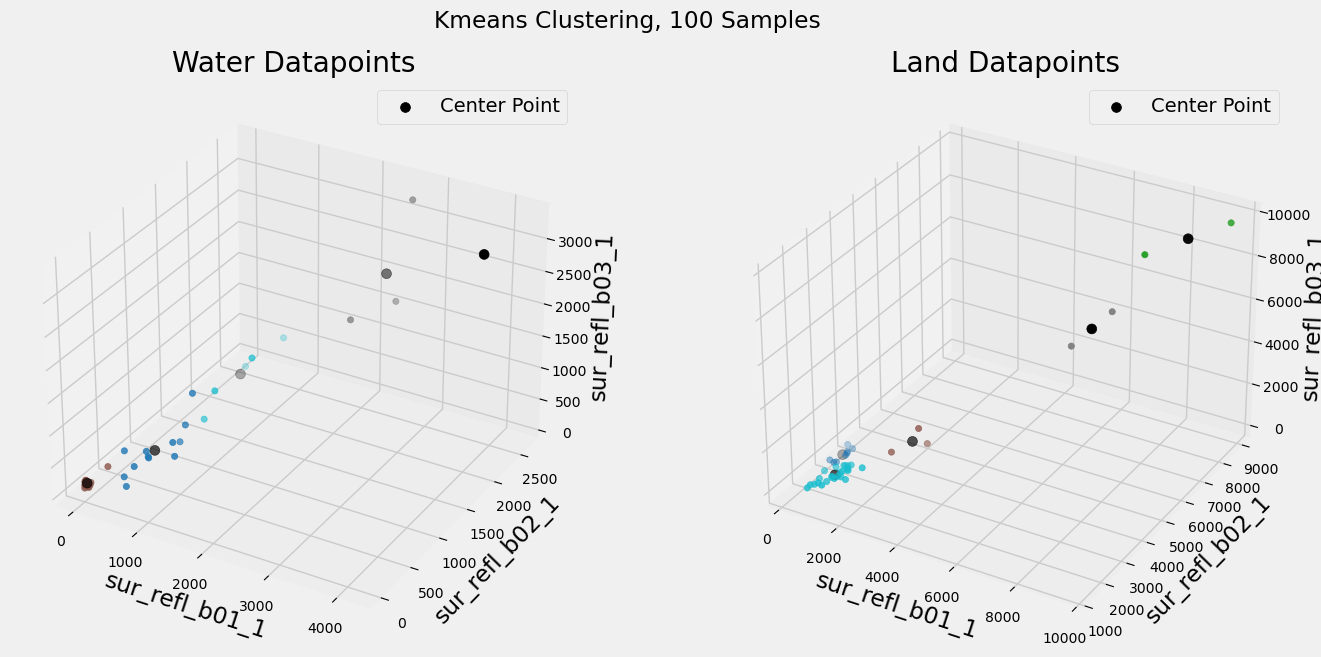

In [93]:
fig = plt.figure(figsize = (15, 7))

plt.suptitle(f'Kmeans Clustering, {num_datapoints} Samples')
ax1 = plt.subplot(121,projection ="3d")
# ax1 = plt.axes(projection ="3d")
ax1.set_title(f'Water Datapoints')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.tick_params(axis='both', which='minor', labelsize=10)

ax1.scatter(X_water_3D.values[:,0], X_water_3D.values[:,1], X_water_3D.values[:,2],
           marker='o',c=kmeans_output_water_3D,cmap='tab10')
ax1.scatter(kme_water_3D.cluster_centers_[:,0],kme_water_3D.cluster_centers_[:,1],kme_water_3D.cluster_centers_[:,2],
            label='Center Point',c='k',s=50)
ax1.legend()
ax1.set_xlabel(X_water_3D.columns[0])
ax1.set_ylabel(X_water_3D.columns[1])
ax1.set_zlabel(X_water_3D.columns[2])


ax2 = plt.subplot(122,projection ="3d")
# ax2 = plt.axes(projection ="3d")
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='minor', labelsize=10)

ax2.set_title(f'Land Datapoints')
ax2.scatter(X_land_3D.values[:,0], X_land_3D.values[:,1], X_land_3D.values[:,2],
           marker='o',c=kmeans_output_land_3D,cmap='tab10')
ax2.scatter(kme_land_3D.cluster_centers_[:,0],kme_land_3D.cluster_centers_[:,1],kme_land_3D.cluster_centers_[:,2],
            label='Center Point',c='k',s=50)
ax2.legend()
ax2.set_xlabel(X_land_3D.columns[0])
ax2.set_ylabel(X_land_3D.columns[1])
ax2.set_zlabel(X_land_3D.columns[2])

plt.show()

### Birch

In [74]:
%%time
br = Birch(n_clusters=5).fit(X)
birch_output = br.predict(X)

CPU times: user 12.4 ms, sys: 11 ms, total: 23.4 ms
Wall time: 27.3 ms


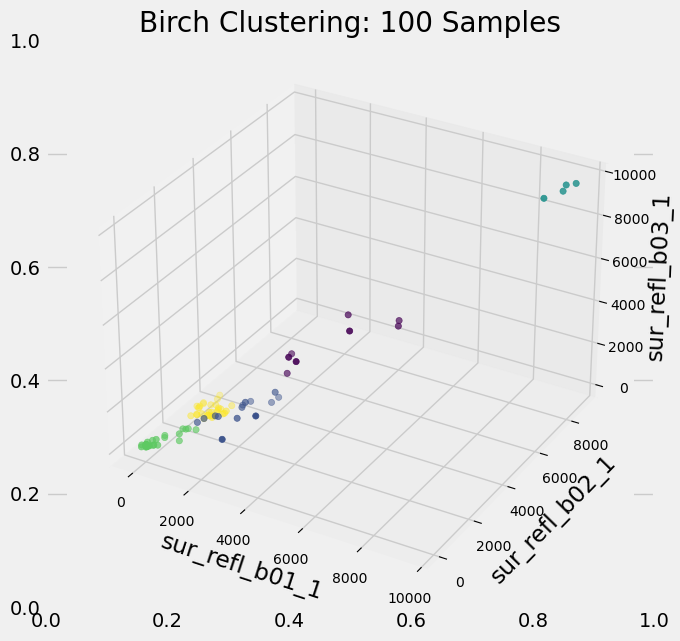

In [76]:
fig = plt.figure(figsize = (7, 7))
plt.title(f'Birch Clustering: {num_datapoints} Samples')
ax = plt.axes(projection ="3d")
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)

ax.scatter(X.values[:,0], X.values[:,1], X.values[:,2],marker='o',c=birch_output)

ax.set_xlabel(X.columns[0])
ax.set_ylabel(X.columns[1])
ax.set_zlabel(X.columns[2])

plt.show()

## Selecting Clustered Training Data

In [37]:
# List of the clusters: kmeans_output_land and kmeans_output_water
# Data: X_water, X_land, y_water, y_land

PERCENT_RANDOM_PULL = 0.1

print(f'pull {COUNT_RANDOM_PULL_WATER} water examples and {COUNT_RANDOM_PULL_LAND} land examples per cluster')

pull 60 water examples and 39 land examples per cluster


In [65]:
np.random.seed(42)
random_ind_land = np.array([])
random_ind_water = []

for cluster in np.unique(kmeans_output_land):
    print(f'cluster {cluster}')

    cluster_ind_water = np.where(kmeans_output_water == cluster)[0]
    COUNT_RANDOM_PULL_WATER = int(0.1*len(cluster_ind_water))
    random_pts_water = np.random.choice(cluster_ind_water,COUNT_RANDOM_PULL_WATER,replace=False)
    random_ind_water = np.append(random_ind_water, random_pts_water)
    
    cluster_ind_land = np.where(kmeans_output_land == cluster)[0]
    COUNT_RANDOM_PULL_LAND = int(0.1*len(cluster_ind_land))
    random_pts_land = np.random.choice(cluster_ind_land,COUNT_RANDOM_PULL_LAND,replace=False)
    random_ind_land = np.append(random_ind_land, random_pts_land)
    print(f'Pulling {COUNT_RANDOM_PULL_WATER} Water pts and {COUNT_RANDOM_PULL_LAND} Land pts')
    print()
random_ind_water = random_ind_water.astype('int')
random_ind_land = random_ind_land.astype('int')

print(random_ind_water,random_ind_land)

cluster 0
Pulling 580 Water pts and 92 Land pts

cluster 1
Pulling 43 Water pts and 90 Land pts

cluster 2
Pulling 3 Water pts and 189 Land pts

[ 540 3432 4272 4624 5290 4749 2010 3809 1430 2999 4568 3658 2716 3873
 2024 2244 4247 4824 4232 6257 6090  176  113 4817 6104 4892 5370 3949
 5046 5868 4451 4030  587  187  863 6098 3386 5461 2146 5060 2412 5035
  647 2764 2505 2345 5712 3980 3914 2898 2311 1842 3241 4010  646 1444
 4237 3651 4871 4383  672 1311  868 3435 4424  503 2858 5646 5539 2324
 4172 5025 1133 1713 2592 1386 3473 5968 1266 2440 3986 1427 1496 1535
 1947  761 3966 6014 2567 5810 2425 1536 6066 4628 3989 3023  814  442
 3316 1296  175 3006  282  632 1526 2106  146 6206 2795  581 1749 2450
 5777 1287 6176  220 4641 1751 3212  620 3519 4600 4063  734 5601 1930
 2710 4125  965 1273 3561 2918 2042 3974 3671  407 1081  198  991 3145
 1282 5848   87 4724 4093  768 5053 2826  871 2128 4406  674  261 2351
 4343 1664 5279 1055 2413 2421 2537 1375 2901 5212 1794 1915 1298 1876
  3

### Total random dataset used for training random forest

In [82]:
X_random_land = X_land.iloc[random_ind_land]
y_random_land = y_land.iloc[random_ind_land]
X_random_water = X_water.iloc[random_ind_water]
y_random_water = y_water.iloc[random_ind_water]

X_random = pd.concat([X_random_land,X_random_water])
y_random = pd.concat([y_random_land,y_random_water])

#Combine the data so that we can shuffle the indices and keep the data together that should be
All_data = pd.concat([X_random,y_random],axis=1).sample(frac=1)

X_random_rfa = All_data[X_random.columns]
y_random_rfa = All_data['water']

In [85]:
print(All_data)
print(X_random_rfa)
print(y_random_rfa)

         sur_refl_b01_1  sur_refl_b02_1  water
255391              245            3182      0
3764924             224              97      1
338964              248               4      1
1951872              25              -2      1
3513397             103             -41      1
...                 ...             ...    ...
3091936              52              -5      1
1729211             136              18      1
293122              175            3474      0
2632380              -8              -2      1
3325256             654            2720      0

[997 rows x 3 columns]
         sur_refl_b01_1  sur_refl_b02_1
255391              245            3182
3764924             224              97
338964              248               4
1951872              25              -2
3513397             103             -41
...                 ...             ...
3091936              52              -5
1729211             136              18
293122              175            3474
2632380     

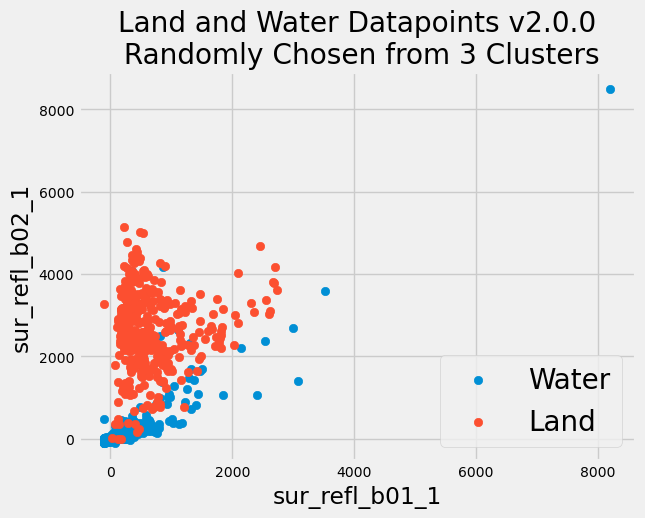

In [89]:
ax = plt.subplot(111)
ax.scatter(X_random_water.values[:,0], X_random_water.values[:,1],label='Water')
ax.scatter(X_random_land.values[:,0], X_random_land.values[:,1],label='Land')
ax.set_title(f'Land and Water Datapoints {DATA_VERSION}'+ 
    f'\n Randomly Chosen from {len(np.unique(kmeans_output_land))} Clusters')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend(loc='lower right',fontsize="20")
ax.set_xlabel(X_random_water.columns[0])
ax.set_ylabel(X_random_water.columns[1])

plt.show()

# Random forest training